# Baseline Model
## Import necessary libraries

In [3]:
!pip install imbalanced-learn
!pip install s3fs

  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)


In [43]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
from sagemaker.feature_store.feature_group import FeatureGroup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import time

### SageMaker Session and Role

In [44]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
athena_client = boto3.client('athena')
bucket = sagemaker_session.default_bucket()

# define feature groups
device_feature_group_name = "device-feature-group-07-18-04-51"
metrics_feature_group_name = "metrics-feature-group-07-18-04-51"

device_feature_group = FeatureGroup(name=device_feature_group_name, sagemaker_session=sagemaker_session)
metrics_feature_group = FeatureGroup(name=metrics_feature_group_name, sagemaker_session=sagemaker_session)

## Fetch data from feature groups using Athena queries

In [45]:
def get_feature_group_data(feature_group, sagemaker_session):
    query = feature_group.athena_query()
    table = query.table_name
    database = query.database
    query_string = f"SELECT * FROM {database}.{table}"
    
    output_location = f"s3://{sagemaker_session.default_bucket()}/athena_query_results/"
    
    athena_client = sagemaker_session.boto_session.client('athena')
    
    response = athena_client.start_query_execution(
        QueryString=query_string,
        QueryExecutionContext={'Database': database},
        ResultConfiguration={'OutputLocation': output_location}
    )
    
    query_execution_id = response['QueryExecutionId']
    
    while True:
        response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
        state = response['QueryExecution']['Status']['State']
        if state in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
            break
        time.sleep(5)
    
    if state == 'SUCCEEDED':
        all_results = []
        
        paginator = athena_client.get_paginator('get_query_results')
        for page in paginator.paginate(QueryExecutionId=query_execution_id):
            all_results.extend(page['ResultSet']['Rows'])
        
        if all_results:
            columns = [col['VarCharValue'] for col in all_results[0]['Data']]
            data = []
            for row in all_results[1:]:  # Skip the header
                data.append([field.get('VarCharValue', '') for field in row['Data']])

            df = pd.DataFrame(data, columns=columns)

            # Remove unnecessary columns
            columns_to_remove = ['write_time', 'api_invocation_time', 'is_deleted']
            df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])

            # Convert data types
            for col in df.columns:
                if col.lower() == 'eventtime':  # Case-insensitive check
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                elif col in ['device', 'rolling_mean_metric1', 'rolling_mean_metric5', 'rolling_mean_metric6',
                             'metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9',
                             'metric2_log', 'metric3_log', 'metric4_log', 'metric7_log', 'metric8_log', 'metric9_log']:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                elif col == 'failure':
                    df[col] = df[col].astype(int)

            return df
        else:
            return pd.DataFrame()  # Return an empty DataFrame if no results
    else:
        raise Exception(f"Query failed with state: {state}")

#### Data Checks

In [46]:
# Fetch data from feature groups
print("Fetching data from feature groups...")
device_data = get_feature_group_data(device_feature_group, sagemaker_session)
metrics_data = get_feature_group_data(metrics_feature_group, sagemaker_session)

# Print information about the retrieved data
print("\nDevice data info:")
print(device_data.info())
print("\nMetrics data info:")
print(metrics_data.info())

# Print some sample rows
print("\nSample rows from device data:")
print(device_data.head())
print("\nSample rows from metrics data:")
print(metrics_data.head())

# Check unique values in some columns
print("\nUnique values in device data 'device' column:")
print(device_data['device'].nunique())
print("\nUnique values in metrics data 'device' column:")
print(metrics_data['device'].nunique())

print("\nUnique values in metrics data 'failure' column:")
print(metrics_data['failure'].value_counts())

# Check if all rows are unique
print("\nNumber of unique rows in device data:")
print(device_data.drop_duplicates().shape[0])
print("\nNumber of unique rows in metrics data:")
print(metrics_data.drop_duplicates().shape[0])

# Print the query used to fetch the data
print("\nQuery used for device data:")
print(device_feature_group.athena_query().table_name)
print("\nQuery used for metrics data:")
print(metrics_feature_group.athena_query().table_name)

Fetching data from feature groups...

Device data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   recordid              124494 non-null  object 
 1   eventtime             124494 non-null  float64
 2   device                124494 non-null  float64
 3   rolling_mean_metric1  124494 non-null  float64
 4   rolling_mean_metric5  124494 non-null  float64
 5   rolling_mean_metric6  124494 non-null  float64
dtypes: float64(5), object(1)
memory usage: 5.7+ MB
None

Metrics data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   recordid     124494 non-null  object 
 1   eventtime    124494 non-null  float64
 2   device       124494 non-null  float64
 3   failure   

In [47]:
# print column names for both dataframes
print("Device data columns:", device_data.columns)
print("Metrics data columns:", metrics_data.columns)

# identify common columns for merging
common_columns = list(set(device_data.columns) & set(metrics_data.columns))
print("Common columns:", common_columns)

# check the data shapes
print("Device data shape:", device_data.shape)
print("Metrics data shape:", metrics_data.shape)

Device data columns: Index(['recordid', 'eventtime', 'device', 'rolling_mean_metric1',
       'rolling_mean_metric5', 'rolling_mean_metric6'],
      dtype='object')
Metrics data columns: Index(['recordid', 'eventtime', 'device', 'failure', 'metric1', 'metric2',
       'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8',
       'metric9', 'metric2_log', 'metric3_log', 'metric4_log', 'metric7_log',
       'metric8_log', 'metric9_log'],
      dtype='object')
Common columns: ['eventtime', 'recordid', 'device']
Device data shape: (124494, 6)
Metrics data shape: (124494, 19)


In [48]:
# display information for both dataframes
print("\nDevice data info:")
print(device_data.info())

print("\nMetrics data info:")
print(metrics_data.info())

# check for missing values
print("\nMissing values in device data:")
print(device_data.isnull().sum())

print("\nMissing values in metrics data:")
print(metrics_data.isnull().sum())


Device data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   recordid              124494 non-null  object 
 1   eventtime             124494 non-null  float64
 2   device                124494 non-null  float64
 3   rolling_mean_metric1  124494 non-null  float64
 4   rolling_mean_metric5  124494 non-null  float64
 5   rolling_mean_metric6  124494 non-null  float64
dtypes: float64(5), object(1)
memory usage: 5.7+ MB
None

Metrics data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   recordid     124494 non-null  object 
 1   eventtime    124494 non-null  float64
 2   device       124494 non-null  float64
 3   failure      124494 non-null  int64  
 4   metr

In [49]:
if 'failure' in metrics_data.columns:
    print("\nFailure statistics:")
    print(metrics_data['failure'].value_counts(normalize=True))
    print(f"Total failures: {metrics_data['failure'].sum()}")

# Identify common columns for merging
common_columns = list(set(device_data.columns) & set(metrics_data.columns))
print("\nCommon columns:", common_columns)


Failure statistics:
failure
0    0.999149
1    0.000851
Name: proportion, dtype: float64
Total failures: 106

Common columns: ['eventtime', 'recordid', 'device']


### Merge Data

In [51]:
merged_data = pd.merge(device_data, metrics_data, on=['recordid', 'eventtime', 'device'])

#### No sampling for baseline model

In [55]:
# Prepare features and target
features = ['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 
            'metric7', 'metric8', 'metric9', 'rolling_mean_metric1', 
            'rolling_mean_metric5', 'rolling_mean_metric6']
target = 'failure'
X = merged_data[features]
y = merged_data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
# print information about the merged dataframe
print("\nMerged data info:")
print(merged_data.info())

# sample of merged data
print("\nSample of merged data:")
print(merged_data.head())


Merged data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   recordid              124494 non-null  object 
 1   eventtime             124494 non-null  float64
 2   device                124494 non-null  float64
 3   rolling_mean_metric1  124494 non-null  float64
 4   rolling_mean_metric5  124494 non-null  float64
 5   rolling_mean_metric6  124494 non-null  float64
 6   failure               124494 non-null  int64  
 7   metric1               124494 non-null  int64  
 8   metric2               124494 non-null  int64  
 9   metric3               124494 non-null  int64  
 10  metric4               124494 non-null  int64  
 11  metric5               124494 non-null  int64  
 12  metric6               124494 non-null  int64  
 13  metric7               124494 non-null  int64  
 14  metric8               124494 non-

### Baseline Log. Reg. Model

In [57]:
# Train the model
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [58]:
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     24878
           1       0.01      0.57      0.02        21

    accuracy                           0.94     24899
   macro avg       0.50      0.76      0.49     24899
weighted avg       1.00      0.94      0.97     24899

ROC AUC Score: 0.7734161756993174


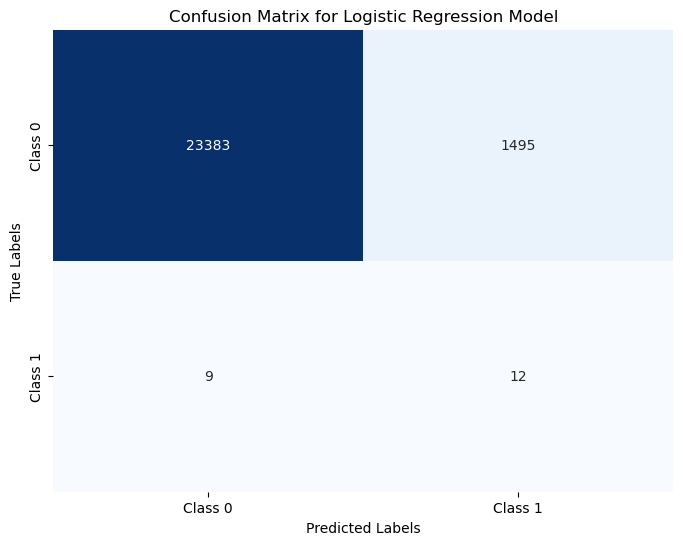

In [59]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

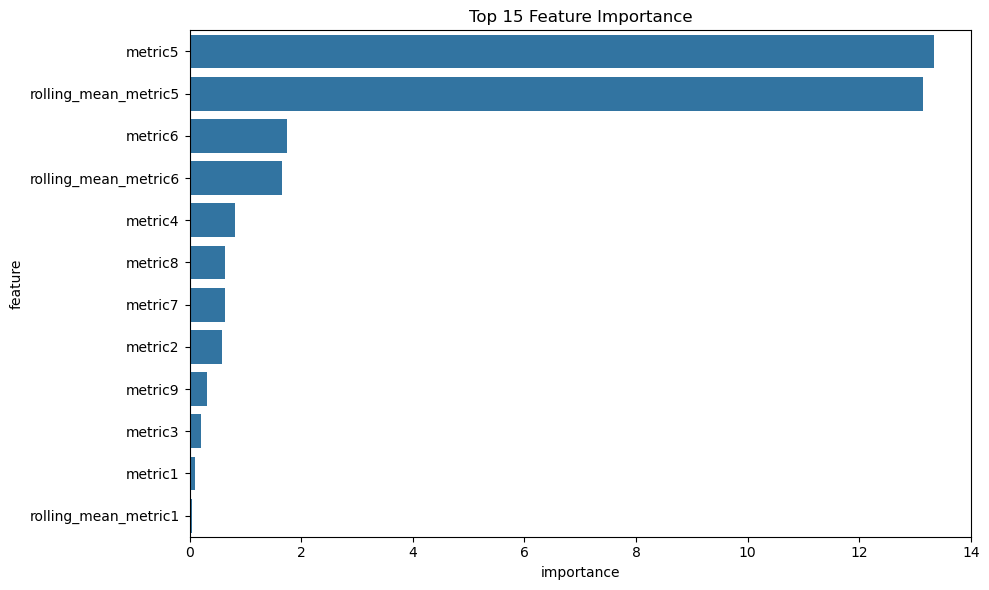

In [60]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

In [61]:
import joblib
def save_preprocessed_data(merged_data):
    # Convert eventtime to Unix timestamp before saving
    #merged_data['eventtime'] = pd.to_numeric(merged_data['eventtime'])
    merged_data.to_csv('preprocessed_maintenance_data.csv', index=False)
    print("Preprocessed data saved as 'preprocessed_maintenance_data.csv'")
    
# Save the model and scaler
def save_model_and_scaler(model, scaler):
    joblib.dump(model, 'baseline_model.joblib')
    print("Model saved as 'baseline_model.joblib'")
    joblib.dump(scaler, 'feature_scaler.joblib')
    print("Scaler saved as 'feature_scaler.joblib'")

save_preprocessed_data(merged_data)
save_model_and_scaler(model, scaler)

Preprocessed data saved as 'preprocessed_maintenance_data.csv'
Model saved as 'baseline_model.joblib'
Scaler saved as 'feature_scaler.joblib'


In [ ]:
# Function to load the saved data and model
def load_model_and_data():
    data = pd.read_csv('preprocessed_maintenance_data.csv')
    
    # Convert eventtime from Unix timestamp to datetime
    #data['eventtime'] = pd.to_datetime(data['eventtime'], unit='s')
    loaded_model = joblib.load('baseline_model.joblib')
    loaded_scaler = joblib.load('feature_scaler.joblib')
    return data, loaded_model, loaded_scaler

# Example of how to use the load function
loaded_data, loaded_model, loaded_scaler = load_model_and_data()

print(loaded_data['eventtime'].dtype)
print(loaded_data['eventtime'].head())

In [39]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>